# Using PyTorch from Keras Example

## Load Data

In [2]:
from keras.datasets import mnist
from keras.utils import np_utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# load MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(60000, 784).astype('float32')
X_test = X_test.reshape(10000, 784).astype('float32')
X_train /= 255.0
X_test /= 255.0

In [4]:
#基本関数
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data

In [5]:
#データセットのDataLoader化
train = torch.utils.data.TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
train_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)
test = torch.utils.data.TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
test_loader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True)

## Full Connected Layer

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784,500)
        self.fc2 = nn.Linear(500, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x))
        return x

model = Net()

In [7]:
#最適化手法
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [8]:
def train(epoch, model):
    model.train()
    loss_history = []
    for _ in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
           
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)
            optimizer.zero_grad()
            output = model(inputs)

            #negative log-likelihood loss
            loss = F.nll_loss(output, labels)
            running_loss += loss.data[0]

            #backpropagation
            loss.backward()
            optimizer.step()
            
        print('[epoch %d]  loss: %.3f' % (_ + 1, running_loss / len(train_loader)))
        loss_history.append(running_loss / len(train_loader))

    return loss_history

In [9]:
history = train(20, model)

[epoch 1]  loss: 1.984
[epoch 2]  loss: 0.793
[epoch 3]  loss: 0.479
[epoch 4]  loss: 0.397
[epoch 5]  loss: 0.357
[epoch 6]  loss: 0.332
[epoch 7]  loss: 0.313
[epoch 8]  loss: 0.297
[epoch 9]  loss: 0.283
[epoch 10]  loss: 0.270
[epoch 11]  loss: 0.258
[epoch 12]  loss: 0.247
[epoch 13]  loss: 0.237
[epoch 14]  loss: 0.227
[epoch 15]  loss: 0.218
[epoch 16]  loss: 0.210
[epoch 17]  loss: 0.201
[epoch 18]  loss: 0.194
[epoch 19]  loss: 0.187
[epoch 20]  loss: 0.180


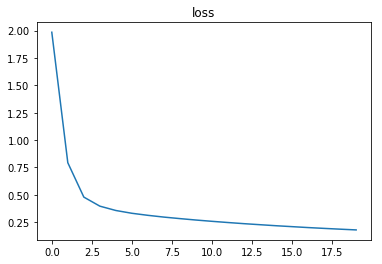

In [10]:
plt.plot(history)
plt.title("loss")
plt.show()

In [11]:
#Accuracy
correct = 0
total = 0
for data in test_loader:
    images, labels = data
    outputs = model(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 95 %


## Auto Encoder

In [12]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.fc1 = nn.Linear(784,500)
        self.fc2 = nn.Linear(500, 84)
        self.fc3 = nn.Linear(84, 500)
        self.fc4 = nn.Linear(500, 784)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

In [13]:
#ネットワーク定義
model_ae = AE()
#最適化手法
optimizer = optim.Adam(model_ae.parameters(), lr=1e-3)
#loss関数の定義
criterion = nn.BCELoss()

In [14]:
def train(epoch, model):
    model.train()
    loss_history = []
    for loop in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
           
            inputs, _ = data
            inputs = Variable(inputs)
            optimizer.zero_grad()
            output = model(inputs)

            loss = criterion(output, inputs) #re-write
            running_loss += loss.data[0]

            #backpropagation
            loss.backward()
            optimizer.step()
            
        print('[epoch %d]  loss: %.3f' % (loop + 1, running_loss / len(train_loader)))
        loss_history.append(running_loss / len(train_loader))

    return loss_history

In [15]:
history = train(10,model_ae)

[epoch 1]  loss: 0.159
[epoch 2]  loss: 0.096
[epoch 3]  loss: 0.087
[epoch 4]  loss: 0.082
[epoch 5]  loss: 0.079
[epoch 6]  loss: 0.077
[epoch 7]  loss: 0.076
[epoch 8]  loss: 0.075
[epoch 9]  loss: 0.074
[epoch 10]  loss: 0.074


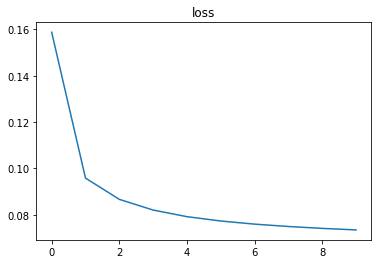

In [16]:
plt.plot(history)
plt.title("loss")
plt.show()

In [17]:
import torchvision

In [18]:
#1バッチ分の画像とラベルの読み込み
dataiter = iter(train_loader)
images, _ = dataiter.next()
outputs = model_ae(Variable(images))

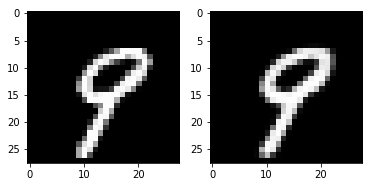

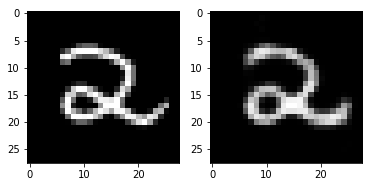

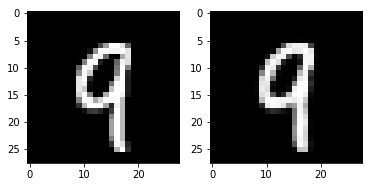

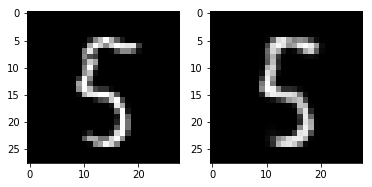

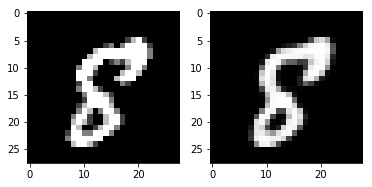

In [19]:
for i in range(5):
    plt.subplot(121)
    plt.imshow(images.numpy()[i].reshape(28,28),cmap='gray')
    plt.subplot(122)
    plt.imshow(outputs.data.numpy()[i].reshape(28,28),cmap='gray')
    plt.show()

## Denoising Auto Encoder

In [96]:
class DAE(nn.Module):
    def __init__(self):
        super(DAE, self).__init__()
        self.fc1 = nn.Linear(784,500)
        self.fc2 = nn.Linear(500, 84)
        self.fc3 = nn.Linear(84, 500)
        self.fc4 = nn.Linear(500, 784)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.sigmoid(self.fc4(x))
        return x

In [104]:
#ネットワーク定義
model_dae = DAE()
#最適化手法
optimizer = optim.Adam(model_dae.parameters(), lr=1e-3)
#loss関数の定義
criterion = nn.BCELoss()

In [105]:
def train(epoch, model):
    model.train()
    loss_history = []
    for loop in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
           
            inputs, _ = data
            inputs = Variable(inputs)
            inputs_noise = inputs + Variable(0.5 * torch.randn(inputs.size()))
            optimizer.zero_grad()
            output = model(inputs_noise)

            loss = criterion(output, inputs) #re-write
            running_loss += loss.data[0]

            #backpropagation
            loss.backward()
            optimizer.step()
            
        print('[epoch %d]  loss: %.3f' % (loop + 1, running_loss / len(train_loader)))
        loss_history.append(running_loss / len(train_loader))

    return loss_history

In [106]:
history = train(10,model_dae)

[epoch 1]  loss: 0.172
[epoch 2]  loss: 0.121
[epoch 3]  loss: 0.113
[epoch 4]  loss: 0.109
[epoch 5]  loss: 0.107
[epoch 6]  loss: 0.106
[epoch 7]  loss: 0.104
[epoch 8]  loss: 0.103
[epoch 9]  loss: 0.103
[epoch 10]  loss: 0.102


In [109]:
#1バッチ分の画像とラベルの読み込み
dataiter = iter(train_loader)
images, labels = dataiter.next()
images_noise = images + 0.5 * torch.randn(inputs.size())
outputs = model_dae(Variable(images_noise))

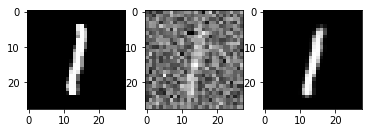

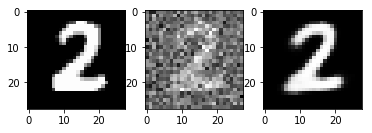

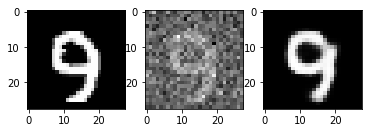

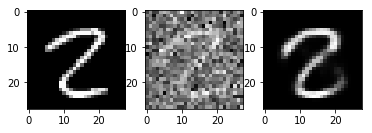

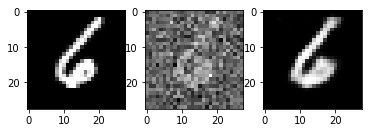

In [111]:
for i in range(5):
    plt.subplot(131)
    plt.imshow(images.numpy()[i].reshape(28,28),cmap='gray')
    plt.subplot(132)
    plt.imshow(images_noise.numpy()[i].reshape(28,28),cmap='gray')
    plt.subplot(133)
    plt.imshow(outputs.data.numpy()[i].reshape(28,28),cmap='gray')
    plt.show()

## Stacked Auto Encoder

In [20]:
class SAE(nn.Module):
    flag = 0
    def __init__(self):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(784,500)
        self.fc2 = nn.Linear(500, 500)
        self.fc3 = nn.Linear(500, 10)
        self.fc3_ = nn.Linear(10,500)
        self.fc2_ = nn.Linear(500, 500)
        self.fc1_ = nn.Linear(500, 784)

    def forward(self, x):
        if(self.flag==1):
            x = F.relu(self.fc1(x))
            x = F.sigmoid(self.fc1_(x))
        elif(self.flag==2):
            self.fc1.requires_grad = False
            self.fc1_.requires_grad = False
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc2_(x))
            x = F.sigmoid(self.fc1_(x))
        elif(self.flag==3):
            self.fc2.requires_grad = False
            self.fc2_.requires_grad = False
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = F.relu(self.fc3_(x))
            x = F.relu(self.fc2_(x))
            x = F.sigmoid(self.fc1_(x))
        elif(self.flag==4): #Fine Tuning
            self.fc1.requires_grad = True
            self.fc1_.requires_grad = True
            self.fc2.requires_grad = True
            self.fc2_.requires_grad = True
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            x = F.relu(self.fc3_(x))
            x = F.relu(self.fc2_(x))
            x = F.sigmoid(self.fc1_(x))
        return x

In [21]:
#ネットワーク定義
model_sae = SAE()
#最適化手法
optimizer = optim.Adam(model_sae.parameters(), lr=1e-3)
#loss関数の定義
criterion = nn.BCELoss()

In [22]:
def train(epoch, model, flag):
    model.train()
    model.flag = flag
    print ("training: " + str(flag))
    loss_history = []
    for loop in range(epoch):
        running_loss = 0.0
        for i, data in enumerate(train_loader):
           
            inputs, _ = data
            inputs = Variable(inputs)
            optimizer.zero_grad()
            output = model(inputs)

            loss = criterion(output, inputs) #re-write
            running_loss += loss.data[0]

            #backpropagation
            loss.backward()
            optimizer.step()
            
        print('[epoch %d]  loss: %.3f' % (loop + 1, running_loss / len(train_loader)))
        loss_history.append(running_loss / len(train_loader))

    return loss_history

In [23]:
history=[]
history.append(train(10,model_sae,1))
history.append(train(10,model_sae,2))
history.append(train(10,model_sae,3))
history.append(train(10,model_sae,4))

training: 1
[epoch 1]  loss: 0.126
[epoch 2]  loss: 0.074
[epoch 3]  loss: 0.069
[epoch 4]  loss: 0.067
[epoch 5]  loss: 0.066
[epoch 6]  loss: 0.066
[epoch 7]  loss: 0.065
[epoch 8]  loss: 0.065
[epoch 9]  loss: 0.065
[epoch 10]  loss: 0.064
training: 2
[epoch 1]  loss: 0.100
[epoch 2]  loss: 0.072
[epoch 3]  loss: 0.069
[epoch 4]  loss: 0.068
[epoch 5]  loss: 0.067
[epoch 6]  loss: 0.067
[epoch 7]  loss: 0.067
[epoch 8]  loss: 0.066
[epoch 9]  loss: 0.066
[epoch 10]  loss: 0.066
training: 3
[epoch 1]  loss: 0.147
[epoch 2]  loss: 0.125
[epoch 3]  loss: 0.120
[epoch 4]  loss: 0.117
[epoch 5]  loss: 0.115
[epoch 6]  loss: 0.113
[epoch 7]  loss: 0.111
[epoch 8]  loss: 0.110
[epoch 9]  loss: 0.109
[epoch 10]  loss: 0.108
training: 4
[epoch 1]  loss: 0.107
[epoch 2]  loss: 0.107
[epoch 3]  loss: 0.106
[epoch 4]  loss: 0.106
[epoch 5]  loss: 0.105
[epoch 6]  loss: 0.105
[epoch 7]  loss: 0.104
[epoch 8]  loss: 0.104
[epoch 9]  loss: 0.103
[epoch 10]  loss: 0.103


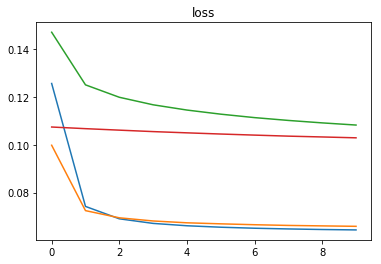

In [24]:
history=np.array(history)
plt.plot(history.T)
plt.title("loss")
plt.show()

### SAEの学習チェック

In [26]:
#1バッチ分の画像とラベルの読み込み
dataiter = iter(train_loader)
images, labels = dataiter.next()
outputs = model_sae(Variable(images))

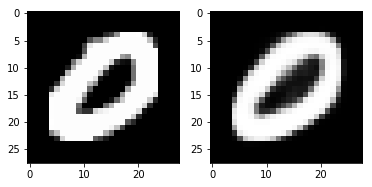

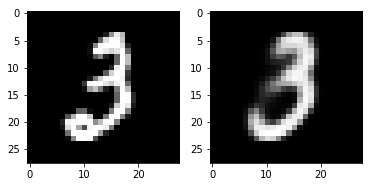

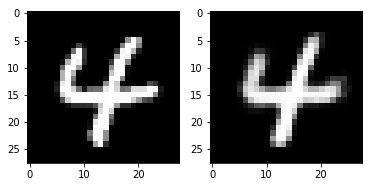

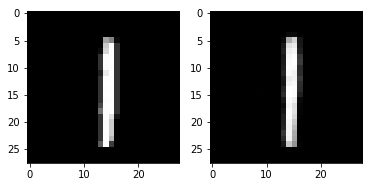

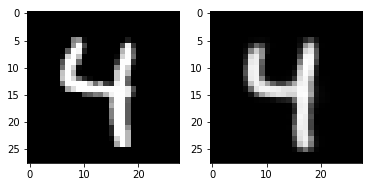

In [27]:
for i in range(5):
    plt.subplot(121)
    plt.imshow(images.numpy()[i].reshape(28,28),cmap='gray')
    plt.subplot(122)
    plt.imshow(outputs.data.numpy()[i].reshape(28,28),cmap='gray')
    plt.show()

### 全データを使った可視化

In [28]:
for i, data in enumerate(train_loader):
    inputs, labels = data
    inputs = Variable(inputs)
    x = F.relu(model_sae.fc1(inputs))
    x = F.relu(model_sae.fc2(x))
    output = F.relu(model_sae.fc3(x))
    if i == 0:
        total_output = output.data
        total_labels = labels
    else:
        total_output = torch.cat([total_output, output.data])
        total_labels = torch.cat([total_labels, labels])

In [30]:
#PCAによる次元削減
from sklearn.decomposition import PCA

In [31]:
pca = PCA(n_components = 2)
pca_x = pca.fit_transform(total_output.numpy())

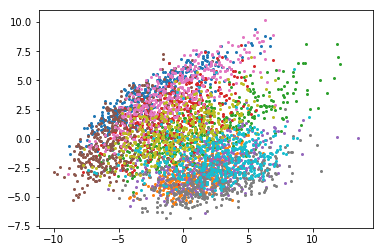

In [41]:
for i in range(10): 
    plot_x = pca_x[np.where(total_labels.numpy()==i),0]
    plot_y = pca_x[np.where(total_labels.numpy()==i),1]
    
    #全部プロットすると時間かかるので400個だけ
    plt.plot(plot_x[0,:400], plot_y[0,:400],'o',markersize=2)

In [42]:
from sklearn.cluster import KMeans

In [63]:
kmeans = KMeans(n_clusters=10, init='random', n_init=10)
kmeans_x = kmeans.fit_transform(total_output.numpy())
kmeans_labels = kmeans.predict(total_output.numpy())

In [64]:
kmeans.cluster_centers_

array([[  0.        ,   5.19611359,   0.        ,   4.77182388,
          5.29166651,  10.50757217,   5.13734531,   6.70772839,
          3.50003076,   6.90334654],
       [  0.        ,   5.03096771,   0.        ,   8.74340439,
          2.93563342,   4.69836235,   4.03926039,   4.90685654,
          4.45519447,   5.80559063],
       [  0.        ,   5.08288288,   0.        ,   2.91908503,
          3.59916615,   2.48964715,   6.18400383,   9.20425224,
          4.65408039,   4.00176859],
       [  0.        ,   3.55596805,   0.        ,   7.89165783,
          5.98406076,   4.77326679,   6.309865  ,   6.73299313,
          4.84238338,   4.20166683],
       [  0.        ,   6.58880043,   0.        ,   6.12519121,
          7.01242924,   3.40310884,   7.13231564,   4.63433933,
          4.1132164 ,   9.0857563 ],
       [  0.        ,   2.94342566,   0.        ,   4.39874363,
          2.67117929,   3.28509068,   3.52643061,   3.13009024,
          2.63067842,   2.40823603],
       [  

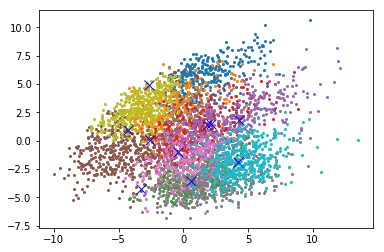

In [68]:
for i in range(10): 
    plot_x = pca_x[np.where(kmeans_labels==i),0]
    plot_y = pca_x[np.where(kmeans_labels==i),1]
    
    #全部プロットすると時間かかるので400個だけ
    plt.plot(plot_x[0,:400], plot_y[0,:400],'o',markersize=2)
    
center = pca.fit_transform(kmeans.cluster_centers_)
plt.plot(center[:,0], center[:,1],'bx',markersize=10)

### 最後に並べて表示

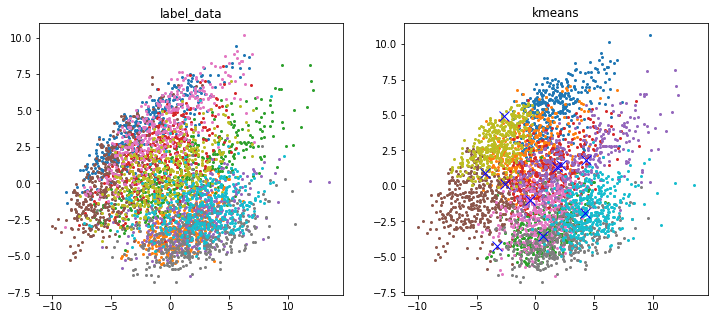

In [71]:
plt.figure(figsize=(12,5))
plt.subplot(121)
for i in range(10): 
    plot_x = pca_x[np.where(total_labels.numpy()==i),0]
    plot_y = pca_x[np.where(total_labels.numpy()==i),1]
    plt.plot(plot_x[0,:400], plot_y[0,:400],'o',markersize=2)
plt.title("label_data")

plt.subplot(122)
for i in range(10): 
    plot_x = pca_x[np.where(kmeans_labels==i),0]
    plot_y = pca_x[np.where(kmeans_labels==i),1]
    plt.plot(plot_x[0,:400], plot_y[0,:400],'o',markersize=2)
    
center = pca.fit_transform(kmeans.cluster_centers_)
plt.plot(center[:,0], center[:,1],'bx',markersize=10)
plt.title("kmeans")